In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import ruptures as rpt

#### 1. Pod adresem [https://www.openml.org](https://www.openml.org) znaleźć można repozytorium wielu zbiorów danych. Należy wybrać jeden, dotyczący problemu regresyjnego dla zbioru danych, które nie zawierają brakujących wartości.

In [5]:
DATA_PATH = "Datasets/space_ga.csv"
TARGET = "ln(VOTES/POP)"

[Link do zbioru](https://www.openml.org/d/507)<br>
Wszystkie cechy są ciągłe

![space](space_ga.png)

In [6]:
df_data = pd.read_csv(DATA_PATH)
df_data.head()

,ln(VOTES/POP),POP,EDUCATION,HOUSES,INCOME,XCOORD,YCOORD
0,-0.661559,9.972920,9.246286,9.004054,12.134915,-86641472.0,32542207.0
1,-0.650859,10.903347,10.221214,9.965758,13.056638,-87754736.0,30654881.0
2,-0.617114,9.722205,8.753529,8.707648,11.630628,-85388993.0,31863073.0
3,-0.639070,9.273691,8.183118,8.277412,11.243712,-87126855.0,32996943.0
4,-0.700274,10.151519,9.207737,9.240676,12.155100,-86566214.0,33979740.0


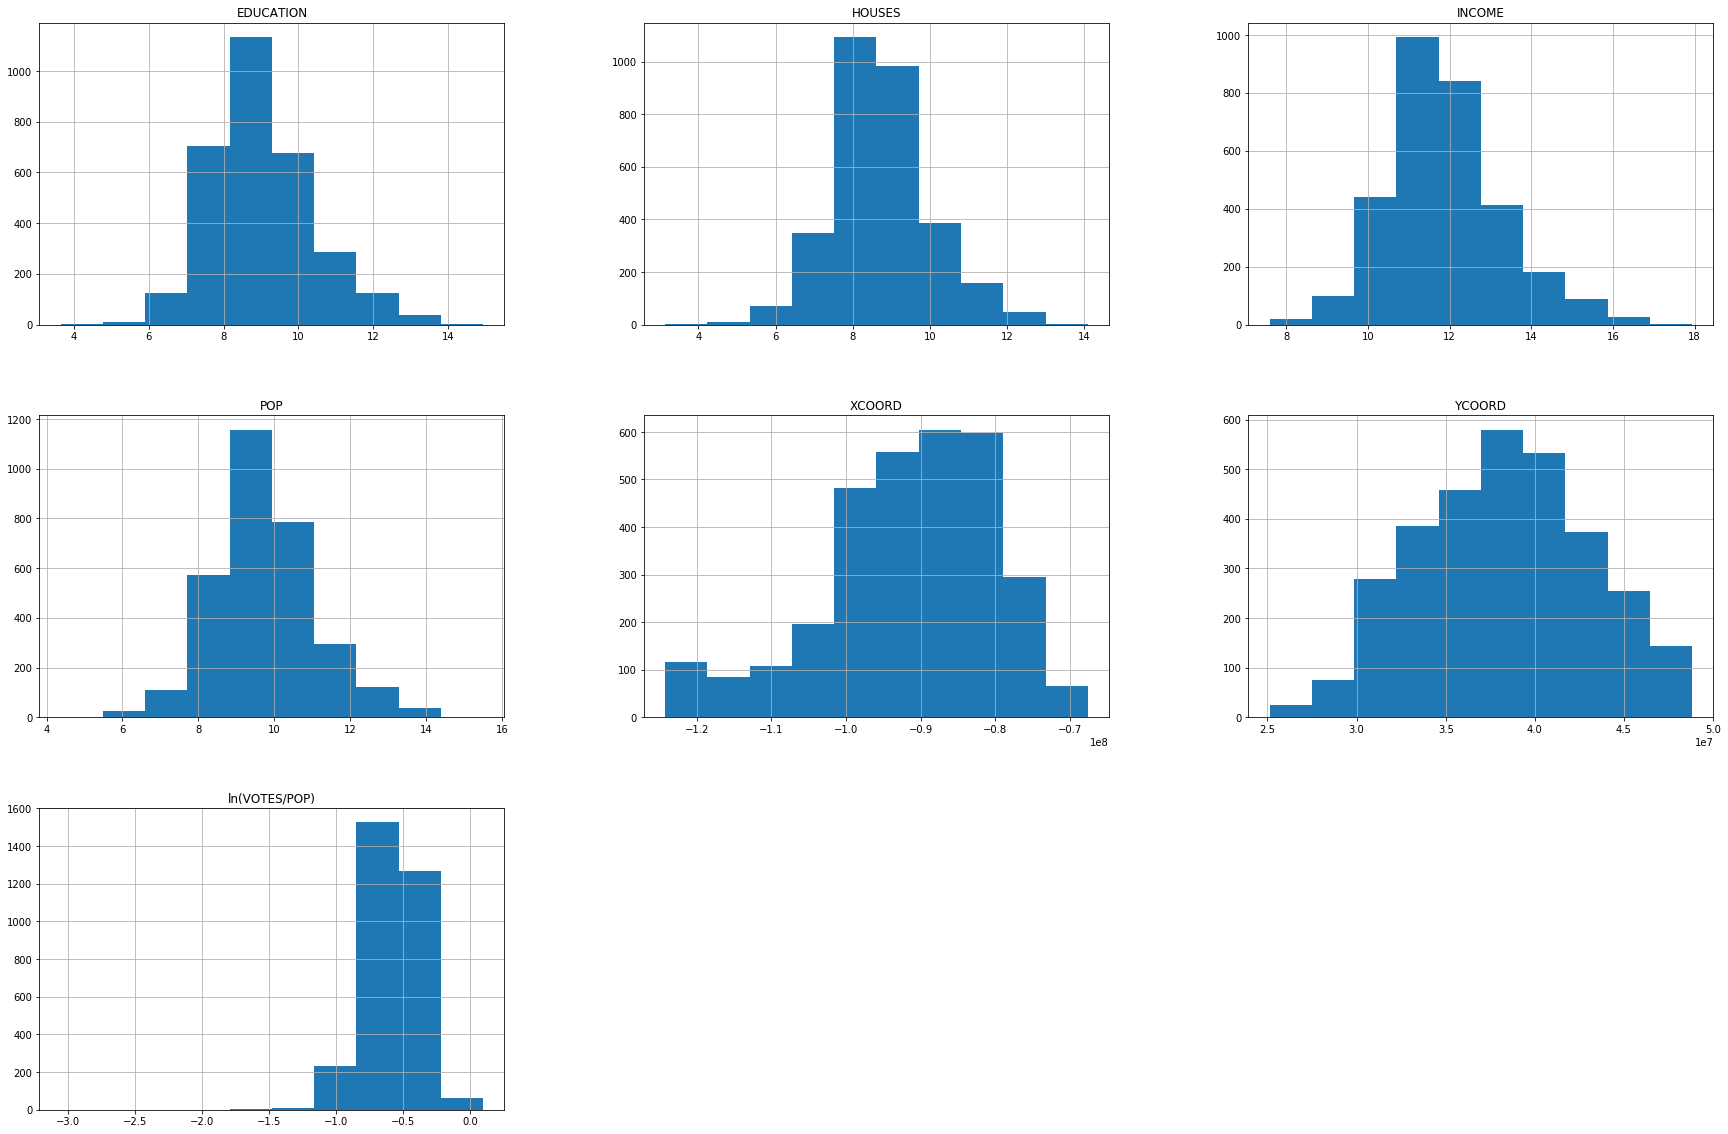

In [7]:
df_data.hist(figsize=(30,20));

## Preprocessing

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [9]:
df_X, df_y = df_data.drop(columns=TARGET), df_data[TARGET]

In [10]:
float_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('float', float_transformer, df_X.columns)])

In [11]:
df_X.iloc[:,:] = preprocessor.fit_transform(df_X)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [13]:
df_X.corr()

,POP,EDUCATION,HOUSES,INCOME,XCOORD,YCOORD
POP,1.000000,0.987472,0.994002,0.992899,0.267719,-0.040601
EDUCATION,0.987472,1.000000,0.984365,0.993133,0.199129,0.047424
HOUSES,0.994002,0.984365,1.000000,0.988084,0.268707,-0.030783
INCOME,0.992899,0.993133,0.988084,1.000000,0.231344,-0.008157
XCOORD,0.267719,0.199129,0.268707,0.231344,1.000000,-0.193174
YCOORD,-0.040601,0.047424,-0.030783,-0.008157,-0.193174,1.000000


#### 2. Dla wybranego zbioru danych (po podziale na uczący i testowy) należy wytrenować dwa elastyczne modele. Dowolne, np. catboost i random forest.

## Models

In [14]:
mse_dict = {}
r2_dict = {}

### XGBRegressor

In [15]:
fix_params_xgb = {"objective": 'reg:linear', "n_estimators": 100}
bb_xgb = XGBRegressor(**fix_params_xgb)

In [16]:
bb_xgb.fit(x_train, y_train)
mse_dict["XGBRegressor"] = mean_squared_error(y_test, bb_xgb.predict(x_test))
print('MSE XGBRegressor: {:2f}'.format(mse_dict["XGBRegressor"]))

MSE XGBRegressor: 0.014206


In [17]:
# R^2
r2_dict["XGBRegressor"] = bb_xgb.score(x_test, y_test)
r2_dict["XGBRegressor"]

0.6560551033995556

### MLPRegressor

In [18]:
fix_params_mlp = {"learning_rate_init": 0.01, "max_iter": 300}
bb_mlp = MLPRegressor(**fix_params_mlp)

In [19]:
bb_mlp.fit(x_train, y_train)
mse_dict["MLPRegressor"] = mean_squared_error(y_test, bb_mlp.predict(x_test))
print('MSE MLPRegressor: {:2f}'.format(mse_dict["MLPRegressor"]))

MSE MLPRegressor: 0.013517


In [20]:
# R^2
r2_dict["MLPRegressor"] = bb_mlp.score(x_test, y_test)
r2_dict["MLPRegressor"]

0.6727260427384548

#### 3. Dla lepszego z tych dwóch modeli, należy wykorzystać techniki typu Partial Dependence Plots / ALE aby przekształcić automatycznie oryginalną zmienną na nową kategoryczną zmienną. Przekształcić należy i zmienne ciągłe i dyskretne.

In [21]:
def ale_plot(model, S, df, k=100):
    estimator = []
    bounded_sum = []
    df_c = df.copy()
    points = np.linspace(df[S].min(), df[S].max(), k)
    bound = df_c[S].quantile(np.linspace(0, 1, k+1)).unique()
    df_c["which_interval"] = df_c[S].apply(lambda x: (x <= bound).argmax())
    df_c_grouped = df_c.groupby(by="which_interval")
    for i, sub_df in df_c_grouped:
        if i == 0:
            bounded_sum.append(0)
            continue
        sub_df = sub_df.drop(columns=["which_interval"])
        df_c1 = sub_df.copy()
        df_c2 = sub_df.copy()
        df_c1[S] = bound[i-1]
        df_c2[S] = bound[i]
        res = (model.predict(df_c2) - model.predict(df_c1)).mean()
        bounded_sum.append(res)
        
    bound_idx_in_use = df_c_grouped.describe().index.values
    bound = bound[bound_idx_in_use]
    bounded_sum = np.array(bounded_sum)
    cum_sum = bounded_sum.cumsum()
    for x in points:
        mask = (x <= bound).argmax()
        est_cum = cum_sum[mask]
        estimator.append((x, est_cum))
    
    estimator = np.array(estimator)
    estimator[:, 1] -= estimator[:,1].mean()
    plt.figure(figsize=(10, 5))
    plt.grid(linewidth=0.5)
    plt.xlabel("feature: {}".format(S))
    plt.ylabel("price centralized")
    plt.plot(estimator[:, 0], estimator[:, 1])
    return estimator[:, 0], estimator[:, 1]
    
def ale_plot_and_breakpoints(model, df, proper_features, k=100):
    breaks_dict = {}
    for feature in proper_features:
        points, est_cum = ale_plot(model=model, S=feature, df=df, k=k)
        algo = rpt.Pelt(model="l1").fit(est_cum)
        result = algo.predict(pen=0.5)
        breaks = []
        for el in result[:-1]:
            breakpoint_x = (points[el-1] + points[el])/2
            plt.axvline(breakpoint_x, color="purple", linestyle = ':')
            breaks.append(breakpoint_x)
        plt.show()
        breaks_dict[feature] = breaks

    return breaks_dict


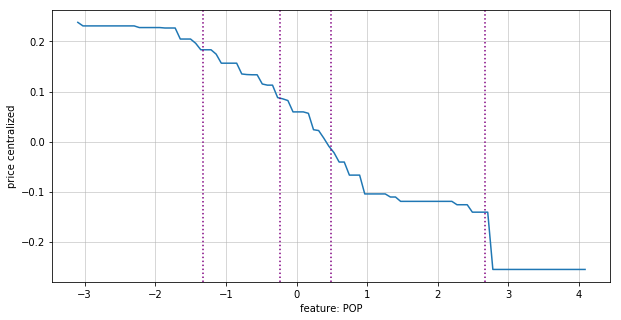

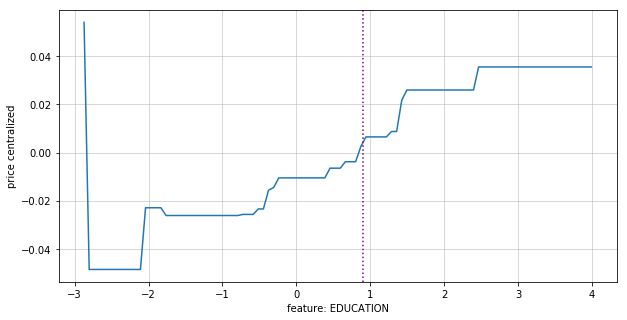

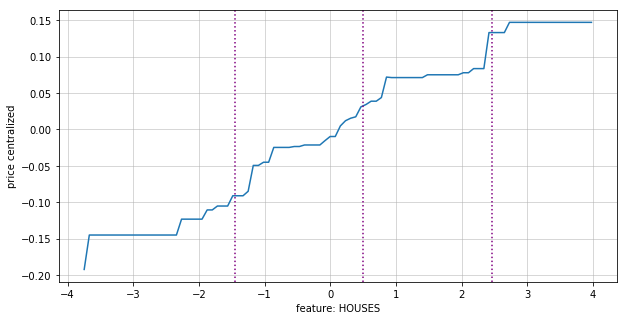

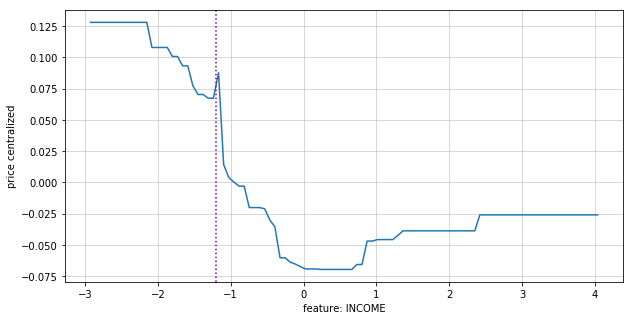

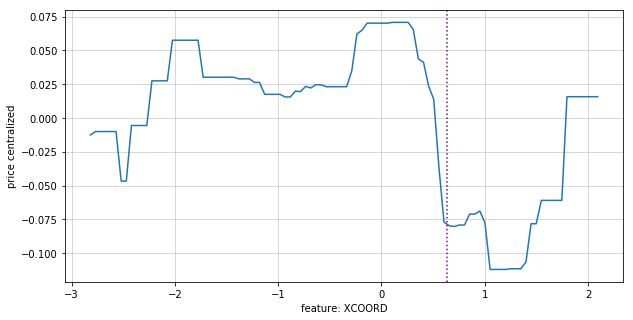

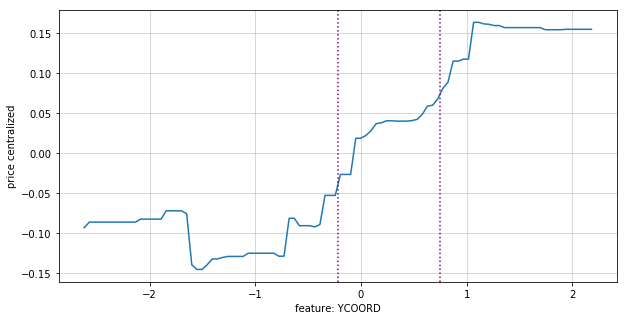

In [22]:
breaks_dict = ale_plot_and_breakpoints(model=bb_xgb, df=x_train, proper_features=x_train.columns, k=100)

In [23]:
def transform_column(x, breaks):
    for i, value in enumerate(breaks):
        if x <= value:
            return i
    return len(breaks)

def transform_features(df, breaks_dict):
    transformed_df = df.copy()
    for feature, breaks in breaks_dict.items():
        transformed_df[feature] = df[feature].apply(lambda x: transform_column(x, breaks))
    return transformed_df

In [24]:
transformed_x_train = transform_features(x_train, breaks_dict)
transformed_x_test = transform_features(x_test, breaks_dict)

#### 4. Na nowym zbiorze danych, wzbogaconym o te nowe zmienne należy zbudować prosty model np regresji liniowej.

##### Po transformacji

In [25]:
wb_lr = LinearRegression()
wb_lr.fit(transformed_x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
mse_dict["LinearRegression TR"] = mean_squared_error(y_test, wb_lr.predict(transformed_x_test))
print('MSE LinearRegression TR: {:2f}'.format(mse_dict["LinearRegression TR"]))

MSE LinearRegression TR: 0.020082


In [27]:
# R^2
r2_dict["LinearRegression TR"] = wb_lr.score(transformed_x_test, y_test)
r2_dict["LinearRegression TR"]

0.5137862444167998

##### Przed

In [28]:
wb_lr = LinearRegression()
wb_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
mse_dict["LinearRegression"] = mean_squared_error(y_test, wb_lr.predict(x_test))
print('MSE LinearRegression: {:2f}'.format(mse_dict["LinearRegression"]))

MSE LinearRegression: 0.019135


In [30]:
# R^2
r2_dict["LinearRegression"] = wb_lr.score(x_test, y_test)
r2_dict["LinearRegression"]

0.5367076360166793

#### 5. Należy porównać skuteczność na zbiorze testowym trzech grup modeli: dwóch wybranych czarnych skrzynek. Modelu regresji wytrenowanego na danych bez transformacji. Modelu wytrenowanego na danych po transformacji.

### XGBRegressor TR

In [31]:
fix_params_xgb = {"objective": 'reg:linear', "n_estimators": 100}
bb_xgb = XGBRegressor(**fix_params_xgb)
bb_xgb.fit(transformed_x_train, y_train)
mse_dict["XGBRegressor TR"] = mean_squared_error(y_test, bb_xgb.predict(transformed_x_test))
print('MSE XGBRegressor TR: {:2f}'.format(mse_dict["XGBRegressor TR"]))

MSE XGBRegressor TR: 0.019267


In [32]:
# R^2
r2_dict["XGBRegressor TR"] = bb_xgb.score(transformed_x_test, y_test)
r2_dict["XGBRegressor TR"]

0.5335202830104502

### MLPRegressor TR

In [33]:
fix_params_mlp = {"learning_rate_init": 0.01, "max_iter": 300}
bb_mlp = MLPRegressor(**fix_params_mlp)
bb_mlp.fit(transformed_x_train, y_train)
mse_dict["MLPRegressor TR"] = mean_squared_error(y_test, bb_mlp.predict(transformed_x_test))
print('MSE MLPRegressor TR: {:2f}'.format(mse_dict["MLPRegressor"]))

MSE MLPRegressor TR: 0.013517


In [34]:
# R^2
r2_dict["MLPRegressor TR"] = bb_mlp.score(transformed_x_test, y_test)
r2_dict["MLPRegressor TR"]

0.498380767359766

## Results

In [35]:
# MSE
pd.DataFrame(mse_dict, index=[0], columns=sorted(mse_dict))

,LinearRegression,LinearRegression TR,MLPRegressor,MLPRegressor TR,XGBRegressor,XGBRegressor TR
0,0.019135,0.020082,0.013517,0.020718,0.014206,0.019267


In [36]:
#R^2
pd.DataFrame(r2_dict, index=[0], columns=sorted(r2_dict))

,LinearRegression,LinearRegression TR,MLPRegressor,MLPRegressor TR,XGBRegressor,XGBRegressor TR
0,0.536708,0.513786,0.672726,0.498381,0.656055,0.53352


Transformacja kolumn nie prowadziła do polepszenia wyniku na żadnej z badanych metryk we wszystkich badanych modelach.<br>
Najlepszym modelem z badanych modeli pod względem wyniku metryk jest MLP dla zadania regresji przed transformacją danych, natomiast po transformacji danych jest nim XGB dla zadania regresji.

Spodziewam się, że wynik będzie się polepszał ze wzrostem parametru podziału wartości danej cechy.